TODO:

- implement wall avoidance
- integrate animation into "world"
- display animation in notebook
- figure out why the boids aren't really changing directions

In [595]:
import numpy as np
import random
from sklearn.preprocessing import normalize

import math

class World():
    def __init__(self, dims):
        self.dims = dims
        self.boids = np.array([])
    
    def setup(self, numBoids):
        for i in range(numBoids):
            self.add_boid()
            
    def add_boid(self):
        self.boids = np.append(self.boids, Boid(self))
        
    def run(self, steps, render=True):
        for b in self.boids:
            b.run()
        if render:
            self.render()
        
    def render(self):
        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=500, interval=20, blit=True)
    

class Boid(object):
    def __init__(self, world):
        self.world = world
        self.boid_num = len(self.world.boids)
        dims = self.world.dims
        x = random.randint(0, dims[0])
        y = random.randint(0, dims[1])
        self.position = np.array([x, y])
        
        direction = random.random()*2*math.pi
        initialSpeed = 1
        vx = math.cos(direction)*initialSpeed
        vy = math.sin(direction)*initialSpeed
        self.velocity = np.array([vx, vy])
        
        self.maxSpeed = 2
        self.maxForce = 0.05
        self.visionAngle = math.radians(180)  # NOTE if angle > 180 is used the finding algo will need to be adjusted <- TODO
        self.desiredDist = random.randint(15,35)
        self.visionDist = self.desiredDist + random.randint(75, 100)
        
        self.seenBoids = np.array([])
        self.acceleration = np.array([0, 0])
        
    def run(self):
        '''
        Find visible boids
        Separate
        Align
        Cohesion
        Avoid obstacles
        Apply Acceleration
        '''
        self.find_boids()
        
        # get forces
        sep = self.separate()
        ali = self.align()
        coh = self.cohesion()
        avo = self.avoid()
        
        sep = 1.5 * sep
        ali = .5 * ali
        coh = 1.0 * coh
        avo = 2.0 * avo
        per = 0.25 * np.random.random((2,))
        forces = [sep, ali, coh, avo]
        #print(forces)
        self.applyForces(forces)
        
        self.update()
    
    def update(self):
        '''

        '''
        self.velocity = self.velocity + self.acceleration
        self.velocity = self.maxSpeed / np.sqrt(self.velocity @ self.velocity) * self.velocity
        self.position = self.position + self.velocity
        self.acceleration = 0 * self.acceleration
    
    def applyForces(self, forces):
        '''
        
        '''
        for f in forces:
            self.acceleration = self.acceleration + f
        
    def find_boids(self):
        '''
        This method finds boids that are within the vision distance and vision angle based on velocity direction
        '''
        dist_vecs = np.array([boid.position - self.position for boid in self.world.boids])
        mags = np.sqrt((dist_vecs*dist_vecs).sum(axis=1)) #TODO: need to check if this multiplication is done correctly '*' might not be the correct multiplication
        nearbyBoids = self.world.boids[mags < self.visionDist]

        relPoints = dist_vecs[mags < self.visionDist]
        theta = self.visionAngle/2

        clockRotationMatrix = np.array([[math.cos(-theta), -math.sin(-theta)], [math.sin(-theta), math.cos(-theta)]])
        counterRotationMatrix = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
        
        sectorStart = np.matmul(clockRotationMatrix, self.velocity)
        sectorEnd = np.matmul(counterRotationMatrix, self.velocity)
        
        visible = [not self.areClockwise(sectorStart, p) and self.areClockwise(sectorEnd, p) for p in relPoints]
        self.seenBoids = nearbyBoids[visible]
        
    def separate(self):
        count = 0
        steer = np.array([0, 0])
        for boid in self.seenBoids:
            diff = self.position - boid.position
            mag = np.sqrt(diff @ diff)
            if( mag > 0 and mag < self.desiredDist ):
                diff = diff / mag
                steer = steer + diff
                count += 1
        if count > 1:
            steer /= count

        steerMag = np.sqrt(steer @ steer)
        if ( steerMag > 0 ):
            steer = steer / steerMag
            steer = self.maxSpeed * steer
            steer -= self.velocity
            steer = self.maxForce / np.sqrt(steer @ steer) * steer
        return steer
    
    def align(self):
        count = len(self.seenBoids)
        steer = np.array([0, 0])
        for boid in self.seenBoids:
            steer = steer + boid.velocity
        
        if count > 1:
            steer /= count

        steerMag = np.sqrt(steer @ steer)
        if ( steerMag > 0 ):
            steer = steer / steerMag
            steer = self.maxSpeed * steer
            steer -= self.velocity
            steer = self.maxForce / np.sqrt(steer @ steer) * steer
        return steer
    
    def cohesion(self):
        count = len(self.seenBoids)
        if count > 0:
            p = np.array([0, 0])
            for boid in self.seenBoids:
                p = p + boid.position
            p = p / count
            desired = p - self.position
            desired = desired / np.sqrt(desired @ desired) * self.maxSpeed
            steer = desired - self.velocity
            steer = self.maxForce / np.sqrt(steer @ steer) * steer
            return steer
        else:
            return np.array([0, 0])
    
    def avoid(self):
        steer = np.array([0, 0])
        if( self.position[0] <= self.visionDist ): # close to x0
            mag = 1 / (self.position[0] + .00001)
            steer = steer + np.array([mag, 0])
        
        if( self.position[0] >= self.world.dims[0] - self.visionDist ): #close to max x
            mag = 1 / (self.position[0] - self.world.dims[0] + .00001)
            steer = steer + np.array([mag, 0])
            
        if( self.position[1] <= self.visionDist ): #close to y0
            mag = 1 / (self.position[1] + .00001)
            steer = steer + np.array([0, mag])

        if( self.position[1] >= self.world.dims[1] - self.visionDist ): #close to max y
            mag = 1 / (self.position[1] - self.world.dims[1]+ .00001)
            steer = steer + np.array([0, mag])
            
        return steer
    
    def __repr__(self):
        return f'Boid {self.boid_num} at {self.position} heading {self.velocity}'
    
    def __str__(self):
        return f'Boid {self.boid_num} at {self.position} heading {self.velocity}'
    
    def areClockwise(self, v1, v2):
        return -v1[0]*v2[1] + v1[1]*v2[0] > 0

In [596]:
world = World((250, 250))
world.setup(100)

In [597]:
world.boids

array([Boid 0 at [67 54] heading [-0.19928842 -0.97994088],
       Boid 1 at [240 210] heading [-0.92350792 -0.38357936],
       Boid 2 at [246  96] heading [-0.9999554  -0.00944421],
       Boid 3 at [105  51] heading [0.59260764 0.80549127],
       Boid 4 at [ 67 165] heading [-0.79891929  0.60143825],
       Boid 5 at [228 173] heading [0.92094753 0.3896866 ],
       Boid 6 at [114 138] heading [ 0.72829012 -0.68526893],
       Boid 7 at [126 138] heading [-0.99533497 -0.0964795 ],
       Boid 8 at [236 116] heading [ 0.49841579 -0.86693812],
       Boid 9 at [56 67] heading [ 0.8633564  -0.50459461],
       Boid 10 at [144  71] heading [-0.96352409  0.26762162],
       Boid 11 at [107  39] heading [-0.99988077  0.01544198],
       Boid 12 at [186 101] heading [ 0.18052796 -0.98356985],
       Boid 13 at [249  64] heading [-0.96504848 -0.26207141],
       Boid 14 at [115 132] heading [ 0.38535759 -0.92276732],
       Boid 15 at [57 55] heading [-0.99776219  0.0668626 ],
       Boid 

In [598]:
for boid in world.boids:
    boid.run()

In [599]:
for boid in world.boids:
    boid.run()

In [600]:
world.boids[0].seenBoids

array([Boid 11 at [103.02327901  39.41781734] heading [-1.98285143  0.26134305],
       Boid 23 at [72.95859762 29.43802716] heading [ 1.98752191 -0.22306202],
       Boid 25 at [101.97918498  13.62447238] heading [ 1.99703011 -0.10895287],
       Boid 32 at [70.33544788  6.42306186] heading [-1.88966752 -0.65510049],
       Boid 35 at [183.24695179  31.10078785] heading [-1.42136403 -1.40702676],
       Boid 39 at [120.12477275  19.09744357] heading [-0.4685876  -1.94433167],
       Boid 49 at [24.33733209  2.53006211] heading [-1.95261723 -0.43276545],
       Boid 51 at [ 7.99549577 36.83962773] heading [ 1.99978248 -0.02949663],
       Boid 62 at [140.86767694  28.98475565] heading [ 1.94675588 -0.45841197],
       Boid 65 at [134.94959206  40.6253261 ] heading [1.9670993  0.36127602],
       Boid 68 at [162.46096511  26.03710108] heading [-0.30410446 -1.97674492],
       Boid 71 at [108.80684037  30.59103068] heading [-1.6039459 -1.1947207],
       Boid 84 at [130.91176453   5.8926

MovieWriter Pillow unavailable; using Pillow instead.


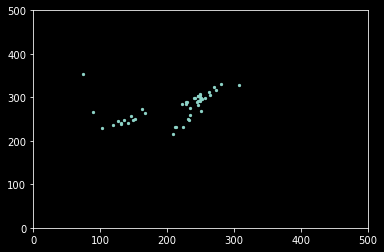

In [602]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 

%matplotlib inline

dims = (500, 500)
world = World(dims)
world.setup(50)

plt.style.use('dark_background')

fig = plt.figure() 
ax = plt.axes(xlim=(0, dims[0]), ylim=(0, dims[1])) 

[b.position for b in world.boids]

scat = ax.scatter([], [], s=5) 

# initialization function 
def init(): 
    # creating an empty plot/frame 
    scat.set_data([], []) 
    return scat

# lists to store x and y axis points 
xdata, ydata = [], [] 

# animation function 
def animate(i): 
    world.run(1, render=False)
    x = np.array([b.position for b in world.boids])[:,0]
    y = np.array([b.position for b in world.boids])[:,0]

    # appending new points to x, y axes points list 
    xdata.append(x) 
    ydata.append(y) 
    scat.set_offsets(np.array([b.position for b in world.boids]))
    return scat 


# hiding the axis details 
#plt.axis('off') 

# call the animator	 
anim = animation.FuncAnimation(fig, animate, frames=1024, interval=20, blit=False) 

# save the animation as mp4 video file 
anim.save('animation.gif', writer='Pillow') 